In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import random

import cv2
import matplotlib.pyplot as plt

In [2]:
# PATH = Path("/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs")
PATH = Path("/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/")
list(PATH.iterdir())

[PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/driver_imgs_list.csv'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/driver_imgs_list.csv.zip'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/sample_submission.csv.zip'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/model1.pth'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/mode_tmp.pth'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/model.pth'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/imgs.zip'),
 PosixPath('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detecti

In [3]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

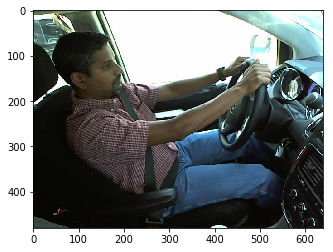

In [4]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)
plt.imshow(im)

In [5]:
im = cv2.imread(str(path))  #.astype(np.float32)/255
im.shape

(480, 640, 3)

In [6]:
# let's look at the typical size of these images
path = PATH/"train/c0"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3)]

In [7]:
# let's look at the typical size of these images
path = PATH/"train/c1"
files = list(path.iterdir())[:200]
dims = [read_image(str(p)).shape for p in files]
dims[:10]

[(480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3),
 (480, 640, 3)]

All pirctures are 480x640 with 3 channels.

## Data augmentation
(Avoid overfitting)

In [8]:
# modified from fast.ai
import math
def center_crop(im, min_sz=None):
    """ Returns a center crop of an image"""
    r,c,*_ = im.shape
    if min_sz is None: min_sz = min(r,c)
    start_r = math.ceil((r-min_sz)/2)
    start_c = math.ceil((c-min_sz)/2)
    return crop(im, start_r, start_c, min_sz, min_sz)

def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

def random_crop(x, target_r, target_c):
    """ Returns a random crop"""
    r,c,*_ = x.shape
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(rand_r*(r - target_r)).astype(int)
    start_c = np.floor(rand_c*(c - target_c)).astype(int)
    return crop(x, start_r, start_c, target_r, target_c)

def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

**Center crop**

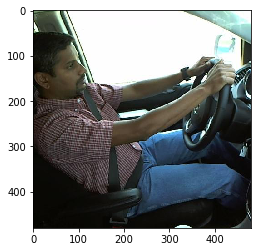

In [9]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)
im = center_crop(im)
plt.imshow(im, cmap='gray')

In [10]:
im.shape

(480, 480, 3)

## Random crop...??

In [11]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)

In [12]:
im.shape

(480, 640, 3)

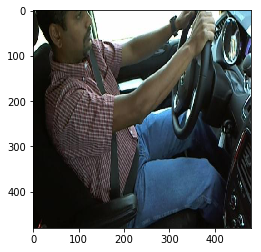

In [13]:
path = PATH/"train/c0/img_34.jpg"
im = read_image(path)

im = cv2.resize(im, (int(480*1.1), int(640*1.1)))
im2 = random_crop(im, 480, 480)
plt.imshow(im2)

## Random rotation

2.0391488158487125


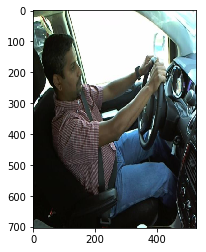

In [14]:
rdeg = (np.random.random()-.50)*20
print(rdeg)
im_rot = rotate_cv(im, rdeg)
plt.imshow(im_rot)

In our case does horizontal flip make sense?

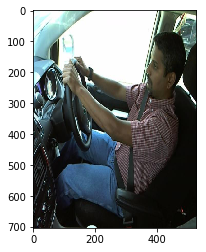

In [15]:
im_f = np.fliplr(im)
plt.imshow(im_f, cmap='gray')

I think center cropping and some rotation will be enough for now

# Split train and validation

In [16]:
import random

Read in dataframe with image files info

In [17]:
# imgs_df = pd.read_csv('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/driver_imgs_list.csv')
imgs_df = pd.read_csv('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/driver_imgs_list.csv')
imgs_df.head()

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


Length of training set:

In [18]:
len(imgs_df)

22424

Length of test set:

In [19]:
path_test = PATH/'test'
len(list(path_test.iterdir()))

79726

Test set is much bigger than training set. Test doesn't include any of the drivers shown in the training set. We will separate a validation set from within the training set making sure there is no driver overlap.

In [20]:
imgs_df.groupby('subject').count()

,classname,img
subject,,
p002,725,725
p012,823,823
p014,876,876
p015,875,875
p016,1078,1078
p021,1237,1237
p022,1233,1233
p024,1226,1226
p026,1196,1196


Validation set:

In [49]:
random.sample(list(imgs_df['subject'].unique()), 5)

['p002', 'p061', 'p064', 'p022', 'p081']

In [21]:
valid_imgs = imgs_df.query("subject in ['p002', 'p061', 'p064', 'p022', 'p081']")
len(valid_imgs)

4410

Training:

In [22]:
train_imgs = imgs_df.query("subject not in ['p002', 'p061', 'p064', 'p022', 'p081']")
len(train_imgs)

18014

ADD paths to dataframes

In [23]:
train_imgs.head()

,subject,classname,img
725,p012,c0,img_10206.jpg
726,p012,c0,img_27079.jpg
727,p012,c0,img_50749.jpg
728,p012,c0,img_97089.jpg
729,p012,c0,img_37741.jpg


In [24]:
#tr_path = '/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/'
tr_path = '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/'

In [25]:
train_imgs['path'] = tr_path + train_imgs['classname'] + '/' + train_imgs['img']

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [26]:
valid_imgs['path'] = tr_path + valid_imgs['classname'] + '/' + valid_imgs['img']

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


ADD labels

In [27]:
train_imgs['label'] = train_imgs['classname'].str[-1].astype(np.int8)
valid_imgs['label'] = valid_imgs['classname'].str[-1].astype(np.int8)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


--------------------------

In [ ]:
path_c0 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c0')
path_c1 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c1')
path_c2 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c2')
path_c3 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c3')
path_c4 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c4')
path_c5 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c5')
path_c6 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c6')
path_c7 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c7')
path_c8 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c8')
path_c9 = Path('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/train/c9')

In [ ]:
path_list = [path_c0, path_c1, path_c2, path_c3, path_c4, path_c5, path_c6, path_c7, path_c8, path_c9]

-------------------------------

In [28]:
train_imgs.head()

,subject,classname,img,path,label
725,p012,c0,img_10206.jpg,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
726,p012,c0,img_27079.jpg,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
727,p012,c0,img_50749.jpg,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
728,p012,c0,img_97089.jpg,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
729,p012,c0,img_37741.jpg,/home/ubuntu/.kaggle/competitions/state-farm-d...,0


In [29]:
train_imgs['path'].values

array(['/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/c0/img_10206.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/c0/img_27079.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/c0/img_50749.jpg',
       ...,
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/c9/img_64532.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/c9/img_7918.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/train/c9/img_84918.jpg'],
      dtype=object)

## Dataset

For now we will resize all images to 240 by 240 after center cropping and rotate the images in the training set by some random amount of degrees.

In [30]:
# When using pre-trained networks you should normalized your images in the same way the
# authors of the model did.
def normalize(im):
    """Normalizes images with Imagenet stats."""
    imagenet_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im - imagenet_stats[0])/imagenet_stats[1]

In [31]:
class DriversDataset(Dataset):
    def __init__(self, df=train_imgs, transforms=False, sz=240):
        self.transforms = transforms
        self.sz = sz
        self.df = df
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        x = row['path']
        x = cv2.imread(x).astype(np.float32)
        x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
        x = cv2.resize(x, (self.sz, self.sz))
        if self.transforms:
            rdeg = (np.random.random()-.50)*20
            x = rotate_cv(x, rdeg)
        # substract numbers from resnet34
        x = normalize(x)
        return np.rollaxis(x, 2), row['label']

In [32]:
train_ds = DriversDataset(df=train_imgs, transforms=True)
valid_ds = DriversDataset(df=valid_imgs)

## Data loaders

In [33]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


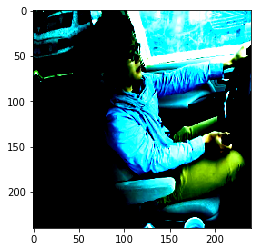

In [34]:
x, y = train_ds[26]
plt.imshow(np.rollaxis(np.rollaxis(x, 2), 2), cmap='gray')

In [ ]:
#F.sigmoid

## Model

In [35]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 10)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        #x = nn.Dropout(0.2)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        #x = nn.Dropout(0.2)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [36]:
model = Net().cuda()

## Learning rate finder

In [37]:
def get_optimizer(model, lr = 0.01, wd = 0.0):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optim = torch.optim.Adam(parameters, lr=lr, weight_decay=wd)
    return optim

In [38]:
def save_model(m, p): torch.save(m.state_dict(), p)
    
def load_model(m, p): m.load_state_dict(torch.load(p))

def LR_range_finder(model, train_dl, lr_low=1e-5, lr_high=1, epochs=2):
    losses = []
    p = PATH/"mode_tmp.pth"
    save_model(model, str(p))
    iterations = epochs * len(train_dl)
    delta = (lr_high - lr_low)/iterations
    lrs = [lr_low + i*delta for i in range(iterations)]
    model.train()
    ind = 0
    for i in range(epochs):
        for x,y in train_dl:
            optim = get_optimizer(model, lr=lrs[ind])
            x = x.cuda().float()
            # y = y.cuda().float().unsqueeze(1)
            y = y.cuda().long()
            out = model(x)
            # loss = F.binary_cross_entropy_with_logits(out, y)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            losses.append(loss.item())
            ind +=1
            
    load_model(model, str(p))
    return lrs, losses

--------------------------

In [43]:
x, y = next(iter(train_dl))

In [38]:
x[0].shape

torch.Size([3, 240, 240])

In [ ]:
x = x.cuda().float()

In [40]:
x

tensor([[[-1.7083e+00, -1.6973e+00, -1.6847e+00,  ..., -4.4716e-01,
          -4.9364e-01, -5.4516e-01],
         [-1.7112e+00, -1.7167e+00, -1.6954e+00,  ..., -3.1989e-01,
          -4.7000e-01, -5.6358e-01],
         [-1.7258e+00, -1.7293e+00, -1.7233e+00,  ..., -1.7388e-01,
          -2.8335e-01, -4.5876e-01],
         ...,
         [-2.0232e+00, -2.0259e+00, -2.0284e+00,  ..., -1.8527e+00,
          -1.9265e+00, -1.9771e+00],
         [-2.0328e+00, -2.0323e+00, -2.0323e+00,  ..., -1.8624e+00,
          -1.9647e+00, -1.9532e+00],
         [-2.0350e+00, -2.0323e+00, -2.0323e+00,  ..., -1.8872e+00,
          -1.9017e+00, -1.9262e+00]],

        [[-1.4649e+00, -1.4306e+00, -1.4178e+00,  ...,  5.4767e-01,
           4.8921e-01,  4.0153e-01],
         [-1.4761e+00, -1.4505e+00, -1.4287e+00,  ...,  6.7778e-01,
           5.1776e-01,  3.8817e-01],
         [-1.4975e+00, -1.4634e+00, -1.4572e+00,  ...,  8.2706e-01,
           7.1405e-01,  4.9971e-01],
         ...,
         [-1.9389e+00, -1

In [42]:
model(x.unsqueeze_(0))

ValueError: Expected more than 1 value per channel when training, got input size [1, 512]

-------------------------------------

In [39]:
model = Net().cuda()
lrs, losses = LR_range_finder(model, train_dl)

In [40]:
lrs

[1e-05,
 0.001783031914893617,
 0.003556063829787234,
 0.005329095744680851,
 0.007102127659574468,
 0.008875159574468085,
 0.010648191489361702,
 0.012421223404255319,
 0.014194255319148936,
 0.015967287234042553,
 0.01774031914893617,
 0.019513351063829787,
 0.021286382978723404,
 0.02305941489361702,
 0.024832446808510638,
 0.026605478723404255,
 0.028378510638297872,
 0.03015154255319149,
 0.03192457446808511,
 0.03369760638297873,
 0.035470638297872344,
 0.03724367021276596,
 0.03901670212765958,
 0.0407897340425532,
 0.04256276595744681,
 0.044335797872340425,
 0.046108829787234046,
 0.047881861702127666,
 0.04965489361702128,
 0.05142792553191489,
 0.053200957446808514,
 0.054973989361702134,
 0.05674702127659575,
 0.05852005319148936,
 0.06029308510638298,
 0.0620661170212766,
 0.06383914893617021,
 0.06561218085106382,
 0.06738521276595745,
 0.06915824468085106,
 0.07093127659574468,
 0.07270430851063829,
 0.0744773404255319,
 0.07625037234042553,
 0.07802340425531915,
 0.0797

In [41]:
losses

[2.360621929168701,
 2.3812761306762695,
 2.2012453079223633,
 2.1871018409729004,
 1.8881351947784424,
 1.7008769512176514,
 1.802460789680481,
 1.6362814903259277,
 1.7051042318344116,
 1.570515513420105,
 1.5332057476043701,
 2.0941052436828613,
 2.124488353729248,
 1.7824751138687134,
 1.6713318824768066,
 1.5138521194458008,
 1.414915680885315,
 2.1921300888061523,
 1.6701693534851074,
 2.335925340652466,
 1.918330430984497,
 1.8711583614349365,
 1.9366134405136108,
 2.2392730712890625,
 1.261672019958496,
 1.6286003589630127,
 2.019500255584717,
 1.9233806133270264,
 1.9211138486862183,
 1.8879162073135376,
 1.6817833185195923,
 1.4852639436721802,
 1.9700846672058105,
 2.604248285293579,
 2.032574415206909,
 2.3501205444335938,
 1.9336990118026733,
 2.4922373294830322,
 2.181492805480957,
 2.497671365737915,
 1.8077501058578491,
 2.29414439201355,
 1.9219822883605957,
 2.458949327468872,
 2.526993751525879,
 3.4367928504943848,
 2.6463794708251953,
 2.9928383827209473,
 4.096045

In [45]:
lrs[10]

0.01774031914893617

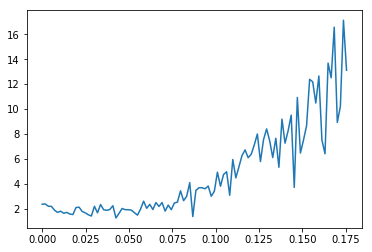

In [44]:
plt.plot(lrs[:100], losses[:100])
plt.show()

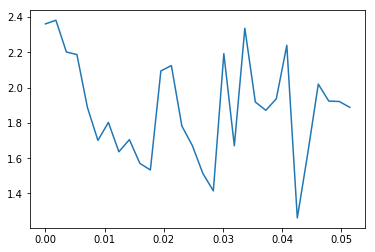

In [43]:
plt.plot(lrs[:30], losses[:30])
plt.show()

## Triangular learning rate training

In [39]:
def get_triangular_lr2(lr_low, lr_high, stepesize):
    iterations = 2*stepesize
    iter1 = int(0.35*iterations)
    iter2 = int(0.85*iter1)
    iter3 = iterations - iter1 - iter2
    delta1 = (lr_high - lr_low)/iter1
    delta2 = (lr_high - lr_low)/(iter1 -1)
    lrs1 = [lr_low + i*delta1 for i in range(iter1)]
    lrs2 = [lr_high - i*(delta1) for i in range(0, iter2)]
    delta2 = (lrs2[-1] - lr_low)/(iter3)
    lrs3 = [lrs2[-1] - i*(delta2) for i in range(1, iter3+1)]
    return lrs1+lrs2+lrs3

In [40]:
def train_triangular_policy(model, train_dl, valid_dl, lr_low=1e-5, lr_high=0.018):
    idx = 0
    epochs = 4
    stepesize = 2*len(train_dl)
    lrs = get_triangular_lr2(lr_low, lr_high, stepesize)
    for i in range(epochs):
        model.train()
        total = 0
        sum_loss = 0
        for i, (x, y) in enumerate(train_dl):
            optim = get_optimizer(model, lr = lrs[idx], wd =0)
            batch = y.shape[0]
            x = x.cuda().float()
            # y = y.cuda().float().unsqueeze(1)
            y = y.cuda().long()
            out = model(x)
            loss = F.cross_entropy(out, y)
            optim.zero_grad()
            loss.backward()
            optim.step()
            idx += 1
            total += batch
            sum_loss += batch*(loss.item())
        print("train loss", sum_loss/total)
        val_metrics(model, valid_dl)
    return sum_loss/total

In [41]:
def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        # y = y.cuda().unsqueeze(1).long()
        y = y.cuda().long()
        out = model(x)
        # pred = (out > 0.0).long()
        pred = torch.max(out, 1)[1]
        correct += pred.eq(y.data).sum().item()
        # y = y.float()
        # loss = F.binary_cross_entropy_with_logits(out, y)
        loss = F.cross_entropy(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)

In [ ]:
"""def val_metrics(model, valid_dl):
    model.eval()
    total = 0
    sum_loss = 0
    correct = 0 
    for i, (x, y) in enumerate(valid_dl):
        batch = y.shape[0]
        x = x.cuda().float()
        # y = y.cuda().unsqueeze(1).long()
        y = y.cuda().long()
        out = model(x)
        pred = (out > 0.0).long()
        correct += pred.eq(y.data).sum().item()
        y = y.float()
        loss = F.binary_cross_entropy_with_logits(out, y)
        sum_loss += batch*(loss.item())
        total += batch
    print("val loss and accuracy", sum_loss/total, correct/total)"""

## Training with triangular rates

In [42]:
from datetime import datetime

def training_loop(model, train_dl, valid_dl, steps=3, lr_low=1e-5, lr_high=0.018):
    for i in range(steps):
        start = datetime.now() 
        loss = train_triangular_policy(model, train_dl, valid_dl, lr_low, lr_high)
        end = datetime.now()
        t = 'Time elapsed {}'.format(end - start)
        print("----End of step", t)

In [43]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [44]:
model = Net().cuda()

In [45]:
training_loop(model, train_dl, valid_dl, steps=1)

train loss 0.6720643474356347
val loss and accuracy 2.886498951533484 0.3825396825396825
train loss 0.34364606275454707
val loss and accuracy 3.1073294863408925 0.445124716553288
train loss 0.11709685477035116
val loss and accuracy 3.070895805704891 0.43560090702947846
train loss 0.06134908694632875
val loss and accuracy 3.238213736129726 0.43900226757369615
----End of step Time elapsed 0:21:39.035333


OVERFITTING

In [61]:
training_loop(model, train_dl, valid_dl, steps=3)

train loss 0.08938031610541118
val loss and accuracy 3.9930260211972692 0.40521541950113377
train loss 0.21865401544819216
val loss and accuracy 4.479250806313253 0.40408163265306124
train loss 0.08940817374522343
val loss and accuracy 4.329535232920225 0.427437641723356
train loss 0.05118579034701501
val loss and accuracy 4.4051781947380295 0.43537414965986393
----End of step Time elapsed 0:21:56.482107
train loss 0.07178607530932428
val loss and accuracy 5.368959851708271 0.41768707482993195
train loss 0.17694451652886642
val loss and accuracy 5.531026723811956 0.4324263038548753
train loss 0.09171496868212956
val loss and accuracy 5.1111231549797145 0.4326530612244898
train loss 0.04768644192629203
val loss and accuracy 5.221856136819403 0.4249433106575964
----End of step Time elapsed 0:21:54.754602
train loss 0.06493672506187445
val loss and accuracy 6.072072514817288 0.41383219954648526
train loss 0.16928201437718604
val loss and accuracy 6.064458107569861 0.4124716553287982
train

## Save model

In [46]:
def save_model(m, p): 
    torch.save(m.state_dict(), p)

In [47]:
p = PATH/"model2.pth"
save_model(model, p)

In [ ]:
# load model
p = PATH/"model2.pth"
model.load_state_dict(torch.load(p))

## Test predictions

In [67]:
val_metrics(model, valid_dl)

val loss and accuracy 3.238213736129726 0.43900226757369615


In [47]:
val_metrics(model, valid_dl)

val loss and accuracy 3.564402711391449 0.40226757369614513


In [48]:
def test_preds(model, test_dl):
    model.eval()
    res = torch.FloatTensor().cuda()
    for i, (x, y) in enumerate(test_dl):
        x = x.cuda().float()
        out = model(x)
        # out = out.long()
        # pred = (out > 0.0).long()
        # pred = torch.max(out, 1)[1]
        res = torch.cat((res, out))
    return res

**Test dataset and dataloader**

In [49]:
# test = pd.read_csv('/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/sample_submission.csv')
test = pd.read_csv('/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/sample_submission.csv')

In [50]:
test.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1


In [51]:
test_set = test.copy()

In [52]:
# test_path = '/Users/ds-lorean/Documents/USF_old/631DLbig/Project_Data/Drivers/imgs/test/'
test_path = '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/'
test_set['path'] = test_path + test_set['img']

In [53]:
test_set['path'].values

array(['/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/img_1.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/img_10.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/img_100.jpg',
       ...,
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/img_99996.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/img_99998.jpg',
       '/home/ubuntu/.kaggle/competitions/state-farm-distracted-driver-detection/test/img_99999.jpg'],
      dtype=object)

In [54]:
test_set['label'] = 0
test_set.head()

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,path,label
0,img_1.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
1,img_10.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
2,img_100.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
3,img_1000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,/home/ubuntu/.kaggle/competitions/state-farm-d...,0
4,img_100000.jpg,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,/home/ubuntu/.kaggle/competitions/state-farm-d...,0


In [55]:
batch_size = 64
test_ds = DriversDataset(df=test_set)
test_dl = DataLoader(test_ds, batch_size=batch_size)

**Predictions**

In [56]:
preds = test_preds(model, test_dl)

In [57]:
preds.shape

torch.Size([79726, 10])

In [58]:
preds[1]

tensor([-18.3383, -21.1931,  -9.7759, -23.6700, -13.4744,  -0.3071,
        -23.8698, -12.7428, -14.5472, -21.8774], device='cuda:0')

**Soft predictions**

In [59]:
soft_preds = F.softmax(preds)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  """Entry point for launching an IPython kernel.


In [60]:
soft_preds

tensor([[ 1.6956e-13,  4.5539e-12,  3.2262e-10,  ...,  3.3474e-12,
          1.2982e-11,  4.9225e-11],
        [ 1.4761e-08,  8.4975e-10,  7.7213e-05,  ...,  3.9738e-06,
          6.5399e-07,  4.2865e-10],
        [ 5.5482e-01,  4.0751e-01,  3.4542e-02,  ...,  1.3288e-04,
          5.1651e-08,  2.2903e-07],
        ...,
        [ 1.1827e-05,  2.0745e-05,  1.6032e-05,  ...,  2.7725e-04,
          9.8049e-01,  1.7633e-03],
        [ 1.6820e-05,  5.9648e-07,  5.2499e-02,  ...,  1.6871e-04,
          1.9939e-07,  2.0713e-06],
        [ 1.0053e-03,  8.3273e-04,  4.5333e-10,  ...,  4.4675e-07,
          8.0821e-04,  1.4006e-04]], device='cuda:0')

**Submission**

In [61]:
submit = test.copy()

In [62]:
ind = 0
for col in list(submit.columns[1:]):
    submit[col] = soft_preds[:,ind].detach()
    ind += 1

In [63]:
submit

,img,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
0,img_1.jpg,1.695558e-13,4.553851e-12,3.226224e-10,1.983016e-05,2.094999e-04,9.997707e-01,1.550811e-11,3.347382e-12,1.298170e-11,4.922481e-11
1,img_10.jpg,1.476059e-08,8.497478e-10,7.721339e-05,7.138442e-11,1.912003e-06,9.999163e-01,5.845572e-11,3.973841e-06,6.539867e-07,4.286547e-10
2,img_100.jpg,5.548220e-01,4.075103e-01,3.454216e-02,6.898630e-09,1.325700e-07,4.559595e-05,2.946689e-03,1.328793e-04,5.165055e-08,2.290263e-07
3,img_1000.jpg,5.446237e-06,1.168714e-07,8.167529e-01,6.542165e-07,8.307486e-04,2.339590e-05,7.601917e-05,1.167900e-07,1.822824e-01,2.819948e-05
4,img_100000.jpg,2.544543e-05,1.290208e-08,3.402800e-07,9.609932e-01,2.042959e-06,4.145544e-05,4.509306e-04,3.744547e-02,1.039807e-03,1.308030e-06
5,img_100001.jpg,3.310825e-07,2.690428e-04,1.384898e-03,8.413445e-01,1.249439e-03,3.788158e-02,3.713171e-07,4.585426e-03,3.942818e-06,1.132804e-01
6,img_100002.jpg,8.649356e-08,2.524224e-10,1.490881e-04,1.006667e-10,4.520235e-03,8.413502e-08,1.452676e-06,1.142141e-09,9.952118e-01,1.172293e-04
7,img_100003.jpg,5.433655e-04,7.721434e-06,1.779714e-06,8.610382e-06,1.403625e-03,1.027785e-03,1.827373e-05,5.125774e-04,1.025959e-02,9.862167e-01
8,img_100004.jpg,1.074446e-03,4.691806e-02,1.603994e-02,8.792832e-05,1.941003e-02,7.806752e-01,6.278551e-02,7.975096e-03,6.400666e-02,1.027120e-03
9,img_100005.jpg,1.441372e-07,2.055647e-12,4.848679e-09,3.076255e-07,1.987231e-05,1.362904e-05,1.918688e-08,9.999659e-01,1.272007e-09,1.278582e-07


In [66]:
submit.to_csv('submission3.csv', index = None)